# **Libraries**

In [833]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.express as px
from sklearn.linear_model import Ridge, LinearRegression
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpContinuous, value

# **Load Data**

In [834]:
Inbound = pd.read_csv('exfolder/Inbound.csv', encoding='utf-8-sig')
Inventory = pd.read_csv('exfolder/Inventory.csv', encoding='utf-8-sig')
MaterialMaster = pd.read_csv('exfolder/MaterialMaster.csv', encoding='utf-8-sig')
OperationCost = pd.read_csv('exfolder/OperationCost.csv', encoding='utf-8-sig')
Outbound = pd.read_csv('exfolder/Outbound.csv', encoding='utf-8-sig')

# **Sample of Each Dataset**

In [835]:
Inbound.shape, Inventory.shape, MaterialMaster.shape, OperationCost.shape, Outbound.shape

((19593, 4), (28328, 8), (431, 4), (4, 4), (26994, 6))

In [836]:
Inbound.sample(5)

,INBOUND_DATE,PLANT_NAME,MATERIAL_NAME,NET_QUANTITY_MT
6030,2024/11/06,SINGAPORE-WAREHOUSE,MAT-0037,24.75
18034,2024/10/09,CHINA-WAREHOUSE,MAT-0332,1.25
3837,2024/07/06,SINGAPORE-WAREHOUSE,MAT-0354,24.75
10181,2024/04/04,CHINA-WAREHOUSE,MAT-0144,25.50
18461,2024/11/19,CHINA-WAREHOUSE,MAT-0013,25.50


In [837]:
Outbound.sample(5)

,OUTBOUND_DATE,PLANT_NAME,MODE_OF_TRANSPORT,MATERIAL_NAME,CUSTOMER_NUMBER,NET_QUANTITY_MT
11285,2024/08/27,CHINA-WAREHOUSE,Truck,MAT-0084,CST-00334,12.380
8579,2024/06/27,CHINA-WAREHOUSE,Truck,MAT-0100,CST-00717,0.150
21885,2024/06/28,SINGAPORE-WAREHOUSE,Marine,MAT-0234,CST-01187,1.375
18898,2024/02/10,SINGAPORE-WAREHOUSE,Marine,MAT-0099,CST-01154,24.750
16028,2024/11/21,CHINA-WAREHOUSE,Truck,MAT-0144,CST-00676,25.500


In [838]:
Inventory.sample(5)

,BALANCE_AS_OF_DATE,PLANT_NAME,MATERIAL_NAME,BATCH_NUMBER,UNRESRICTED_STOCK,STOCK_UNIT,STOCK_SELL_VALUE,CURRENCY
24812,9/30/2024,SINGAPORE-WAREHOUSE,MAT-0354,M6204C,89375,KG,44688,SGD
19726,4/30/2024,SINGAPORE-WAREHOUSE,MAT-0327,M5973A,2750,KG,1843,SGD
4784,5/31/2024,CHINA-WAREHOUSE,MAT-0086,E2769A,28375,KG,215366,CNY
21036,6/30/2024,SINGAPORE-WAREHOUSE,MAT-0364,2814A1415,11000,KG,25410,SGD
7979,7/31/2024,CHINA-WAREHOUSE,MAT-0389,V6029A,160175,KG,1928507,CNY


In [839]:
MaterialMaster.sample(5)

,MATERIAL_NAME,POLYMER_TYPE,SHELF_LIFE_IN_MONTH,DOWNGRADE_VALUE_LOST_PERCENT
213,MAT-0214,P-001,6,15
242,MAT-0243,P-001,4,30
4,MAT-0005,P-002,5,20
191,MAT-0192,P-001,2,5
46,MAT-0047,P-002,3,30


In [840]:
OperationCost

,Operation,Plant/Mode of Transport,Cost,Currency
0,Inventory Storage per MT per day,SINGAPORE WAREHOUSE,15.0,SGD
1,Inventory Storage per MT per day,CHINA WAREHOUSE,1.7,CNY
2,Transfer cost per container (24.75MT),Truck,150.0,SGD
3,Transfer cost per container (24.75MT),Marine,75.0,USD


# **Data Cleaning**

In [841]:
Inventory.isnull().sum()

BALANCE_AS_OF_DATE    0
PLANT_NAME            0
MATERIAL_NAME         0
BATCH_NUMBER          1
UNRESRICTED_STOCK     0
STOCK_UNIT            0
STOCK_SELL_VALUE      0
CURRENCY              0
dtype: int64

In [842]:
Outbound.isnull().sum() 

OUTBOUND_DATE        0
PLANT_NAME           0
MODE_OF_TRANSPORT    0
MATERIAL_NAME        4
CUSTOMER_NUMBER      0
NET_QUANTITY_MT      0
dtype: int64

In [843]:
Inventory.dropna(subset=['BATCH_NUMBER'], inplace=True)
Outbound.dropna(subset=['MATERIAL_NAME'], inplace=True)

In [844]:
Inbound

,INBOUND_DATE,PLANT_NAME,MATERIAL_NAME,NET_QUANTITY_MT
0,2023/12/15,SINGAPORE-WAREHOUSE,MAT-0354,23.375
1,2023/12/22,SINGAPORE-WAREHOUSE,MAT-0413,1.375
2,2023/12/22,SINGAPORE-WAREHOUSE,MAT-0413,23.375
3,2023/12/22,SINGAPORE-WAREHOUSE,MAT-0413,24.750
4,2023/12/22,SINGAPORE-WAREHOUSE,MAT-0413,19.250
...,...,...,...,...
19588,2024/12/24,CHINA-WAREHOUSE,MAT-0118,24.750
19589,2024/12/24,CHINA-WAREHOUSE,MAT-0118,24.750
19590,2024/12/24,CHINA-WAREHOUSE,MAT-0118,24.750
19591,2024/12/24,CHINA-WAREHOUSE,MAT-0118,24.750


In [845]:
# แปลงวันที่ให้เป็น datetime
Inbound['INBOUND_DATE'] = pd.to_datetime(Inbound['INBOUND_DATE'])
Outbound['OUTBOUND_DATE'] = pd.to_datetime(Outbound['OUTBOUND_DATE'])
Inventory['BALANCE_AS_OF_DATE'] = pd.to_datetime(Inventory['BALANCE_AS_OF_DATE'])

Inbound['DATE'] = Inbound['INBOUND_DATE'].dt.date
Outbound['DATE'] = Outbound['OUTBOUND_DATE'].dt.date
Inventory['DATE'] = Inventory['BALANCE_AS_OF_DATE'].dt.date

Inventory['Quantity_KT_Inventory'] = Inventory['UNRESRICTED_STOCK'] / 1000  # 1 KT = 1000000 KG
Inbound['Quantity_KT_In'] = Inbound['NET_QUANTITY_MT'] # / 1000  # 1 KT = 1000 MT
Outbound['Quantity_KT_Out'] = Outbound['NET_QUANTITY_MT'] # / 1000  # 1 KT = 1000 MT

Inventory.drop(columns=['UNRESRICTED_STOCK', 'STOCK_UNIT'], inplace=True)
Inbound.drop(columns=['NET_QUANTITY_MT'], inplace=True)
Outbound.drop(columns=['NET_QUANTITY_MT'], inplace=True)

# **Split Cleaned Data By "PLANT_NAME" (Singapore and China)**

In [846]:
### แบ่ง dataframe ตาม PLANT_NAME ###

# inventory
# raw_inventory_singapore = Inventory[Inventory['PLANT_NAME'] == 'SINGAPORE-WAREHOUSE'].copy()
raw_inventory_china = Inventory[Inventory['PLANT_NAME'] == 'CHINA-WAREHOUSE'].copy()

# inbound
raw_inbound_singapore = Inbound[Inbound['PLANT_NAME'] == 'SINGAPORE-WAREHOUSE'].copy()
raw_inbound_china = Inbound[Inbound['PLANT_NAME'] == 'CHINA-WAREHOUSE'].copy()

# outbound
raw_outbound_singapore = Outbound[Outbound['PLANT_NAME'] == 'SINGAPORE-WAREHOUSE'].copy()
raw_outbound_china = Outbound[Outbound['PLANT_NAME'] == 'CHINA-WAREHOUSE'].copy()

In [847]:
# # inventory
# raw_inventory_china.to_csv("raw_inventory_china.csv", index=False)

# # inbound
# raw_inbound_china.to_csv("raw_inbound_china.csv", index=False)

# # outbound
# raw_outbound_china.to_csv("raw_outbound_china.csv", index=False) 

---

# **Singapore**

In [848]:
raw_inventory_singapore = pd.read_excel('exfolder/Real_Clean_Singapore.xlsx')

In [849]:
raw_inventory_singapore.head()

,BALANCE_AS_OF_DATE,PLANT_NAME,MATERIAL_NAME,BATCH_NUMBER,UNRESTRICTED_STOCK_MT,STOCK_SELL_VALUE
0,2023-12-31,SINGAPORE-WAREHOUSE,MAT-0005,L1883A,4.500,6750
1,2023-12-31,SINGAPORE-WAREHOUSE,MAT-0005,L8442A,10.500,15750
2,2023-12-31,SINGAPORE-WAREHOUSE,MAT-0007,2182A5396,1.350,824
3,2023-12-31,SINGAPORE-WAREHOUSE,MAT-0007,3932A2476,1.275,778
4,2023-12-31,SINGAPORE-WAREHOUSE,MAT-0007,4715A4841,1.350,824


In [850]:
raw_inventory_singapore['Quantity_MT_Inventory'] = raw_inventory_singapore['UNRESTRICTED_STOCK_MT']

### **Time Range Selection**

In [851]:
print("Inbound dates:", raw_inbound_singapore['INBOUND_DATE'].min(), "-", raw_inbound_singapore['INBOUND_DATE'].max())
print("Outbound dates:", raw_outbound_singapore['OUTBOUND_DATE'].min(), "-", raw_outbound_singapore['OUTBOUND_DATE'].max())
print("Inventory dates:", raw_inventory_singapore['BALANCE_AS_OF_DATE'].min(), "-", raw_inventory_singapore['BALANCE_AS_OF_DATE'].max())

Inbound dates: 2023-11-07 00:00:00 - 2024-12-20 00:00:00
Outbound dates: 2023-12-06 00:00:00 - 2025-01-02 00:00:00
Inventory dates: 2023-12-31 00:00:00 - 2024-12-31 00:00:00


In [852]:
start_date = pd.to_datetime('2024-01-01')
end_date   = pd.to_datetime('2024-12-31')

In [853]:
inbound_singapore = raw_inbound_singapore[
    (raw_inbound_singapore['INBOUND_DATE'] >= start_date) & 
    (raw_inbound_singapore['INBOUND_DATE'] <= end_date)
].copy()

outbound_singapore = raw_outbound_singapore[
    (raw_outbound_singapore['OUTBOUND_DATE'] >= start_date) & 
    (raw_outbound_singapore['OUTBOUND_DATE'] <= end_date)
].copy()

inventory_singapore = raw_inventory_singapore[
    (raw_inventory_singapore['BALANCE_AS_OF_DATE'] >= start_date) & 
    (raw_inventory_singapore['BALANCE_AS_OF_DATE'] <= end_date)
].copy()

In [854]:
print("Inbound dates:", inbound_singapore['INBOUND_DATE'].min(), "-", inbound_singapore['INBOUND_DATE'].max())
print("Outbound dates:", outbound_singapore['OUTBOUND_DATE'].min(), "-", outbound_singapore['OUTBOUND_DATE'].max())
print("Inventory dates:", inventory_singapore['BALANCE_AS_OF_DATE'].min(), "-", inventory_singapore['BALANCE_AS_OF_DATE'].max())

Inbound dates: 2024-01-01 00:00:00 - 2024-12-20 00:00:00
Outbound dates: 2024-01-01 00:00:00 - 2024-12-31 00:00:00
Inventory dates: 2024-01-31 00:00:00 - 2024-12-31 00:00:00


---

# **EDA**

### **Monthly of Inventory, Inbound & Outbound**

**Inventory**

In [855]:
inventory_singapore['month'] = inventory_singapore['BALANCE_AS_OF_DATE'].dt.to_period('M').dt.to_timestamp()

Inventory_monthly_singapore = (
    inventory_singapore.groupby(['month', 'PLANT_NAME'])['Quantity_MT_Inventory']
    .sum()
    .reset_index()
)
Inventory_monthly_singapore.head(5)

,month,PLANT_NAME,Quantity_MT_Inventory
0,2024-01-01,SINGAPORE-WAREHOUSE,40213.850
1,2024-02-01,SINGAPORE-WAREHOUSE,36465.800
2,2024-03-01,SINGAPORE-WAREHOUSE,34938.300
3,2024-04-01,SINGAPORE-WAREHOUSE,34619.875
4,2024-05-01,SINGAPORE-WAREHOUSE,35428.425


**Inbound**

In [856]:
inbound_singapore['month'] = inbound_singapore['INBOUND_DATE'].dt.to_period('M').dt.to_timestamp()

Inbound_monthly_singapore = (
    inbound_singapore.groupby(['month', 'PLANT_NAME'])['Quantity_KT_In']
    .sum()
    .reset_index()
)
Inbound_monthly_singapore.head()

,month,PLANT_NAME,Quantity_KT_In
0,2024-01-01,SINGAPORE-WAREHOUSE,6867.000
1,2024-02-01,SINGAPORE-WAREHOUSE,7128.995
2,2024-03-01,SINGAPORE-WAREHOUSE,15858.001
3,2024-04-01,SINGAPORE-WAREHOUSE,14027.350
4,2024-05-01,SINGAPORE-WAREHOUSE,12248.625


**Outbound**

In [857]:
outbound_singapore['month'] = outbound_singapore['OUTBOUND_DATE'].dt.to_period('M').dt.to_timestamp()

Outbound_monthly_singapore = (
    outbound_singapore.groupby(['month', 'PLANT_NAME'])['Quantity_KT_Out']
    .sum()
    .reset_index()
)
Outbound_monthly_singapore.head()

,month,PLANT_NAME,Quantity_KT_Out
0,2024-01-01,SINGAPORE-WAREHOUSE,8030.355
1,2024-02-01,SINGAPORE-WAREHOUSE,10046.795
2,2024-03-01,SINGAPORE-WAREHOUSE,11107.855
3,2024-04-01,SINGAPORE-WAREHOUSE,8797.185
4,2024-05-01,SINGAPORE-WAREHOUSE,10501.950


## **Merge**

In [858]:
df = pd.merge(
    Inbound_monthly_singapore,
    Inventory_monthly_singapore,
    on=['month', 'PLANT_NAME'],
    how='left'
)
df = pd.merge(
    df,
    Outbound_monthly_singapore,
    on=['month', 'PLANT_NAME'],
    how='left'
)
df.fillna(0, inplace=True)
df = df[['month', 'PLANT_NAME', 'Quantity_KT_In', 'Quantity_KT_Out', 'Quantity_MT_Inventory']]
df.head()

,month,PLANT_NAME,Quantity_KT_In,Quantity_KT_Out,Quantity_MT_Inventory
0,2024-01-01,SINGAPORE-WAREHOUSE,6867.000,8030.355,40213.850
1,2024-02-01,SINGAPORE-WAREHOUSE,7128.995,10046.795,36465.800
2,2024-03-01,SINGAPORE-WAREHOUSE,15858.001,11107.855,34938.300
3,2024-04-01,SINGAPORE-WAREHOUSE,14027.350,8797.185,34619.875
4,2024-05-01,SINGAPORE-WAREHOUSE,12248.625,10501.950,35428.425


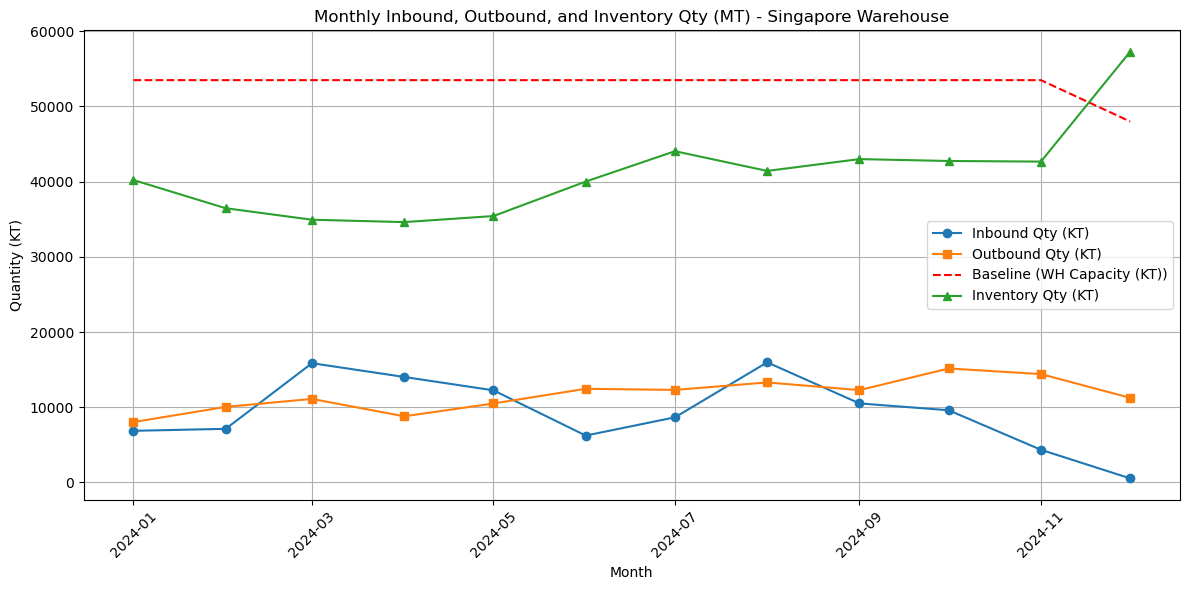

In [859]:
y = [53500] * 11 + [48000]
plt.figure(figsize=(12, 6))
plt.plot(df['month'], df['Quantity_KT_In'], marker='o', label='Inbound Qty (KT)')
plt.plot(df['month'], df['Quantity_KT_Out'], marker='s', label='Outbound Qty (KT)')
plt.plot(df['month'], y, color='r', linestyle='--', label='Baseline (WH Capacity (KT))')
plt.plot(df['month'], df['Quantity_MT_Inventory'], marker='^', label='Inventory Qty (KT)')
plt.title('Monthly Inbound, Outbound, and Inventory Qty (MT) - Singapore Warehouse')
plt.xlabel('Month')
plt.ylabel('Quantity (KT)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

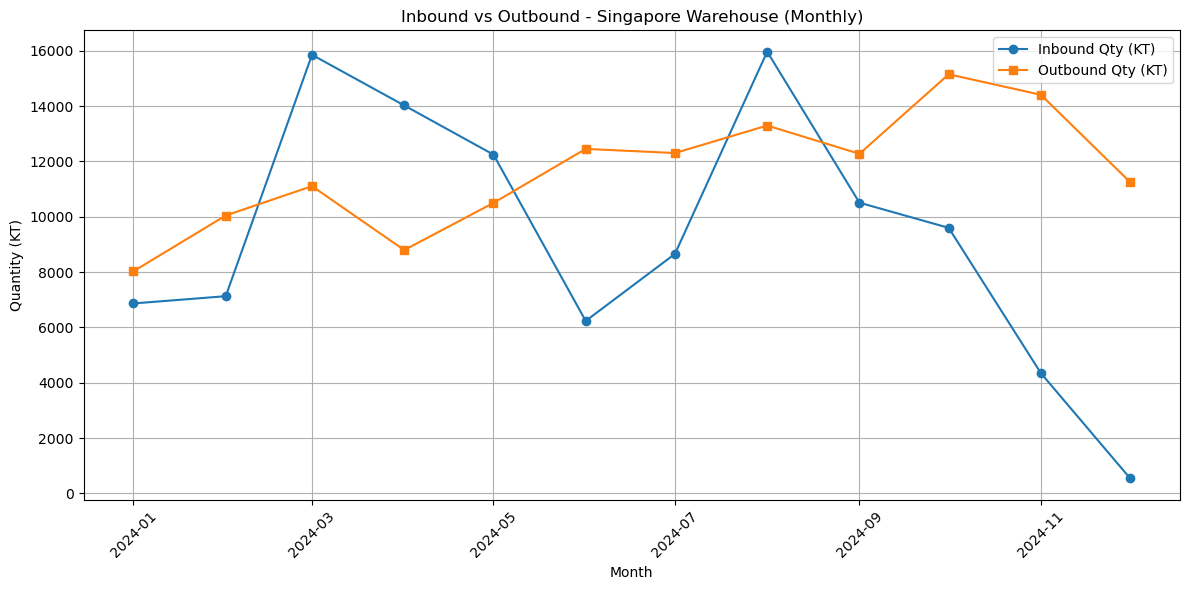

In [860]:
plt.figure(figsize=(12, 6))

plt.plot(df['month'], df['Quantity_KT_In'], marker='o', label='Inbound Qty (KT)')
plt.plot(df['month'], df['Quantity_KT_Out'], marker='s', label='Outbound Qty (KT)')

plt.title('Inbound vs Outbound - Singapore Warehouse (Monthly)')
plt.xlabel('Month')
plt.ylabel('Quantity (KT)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

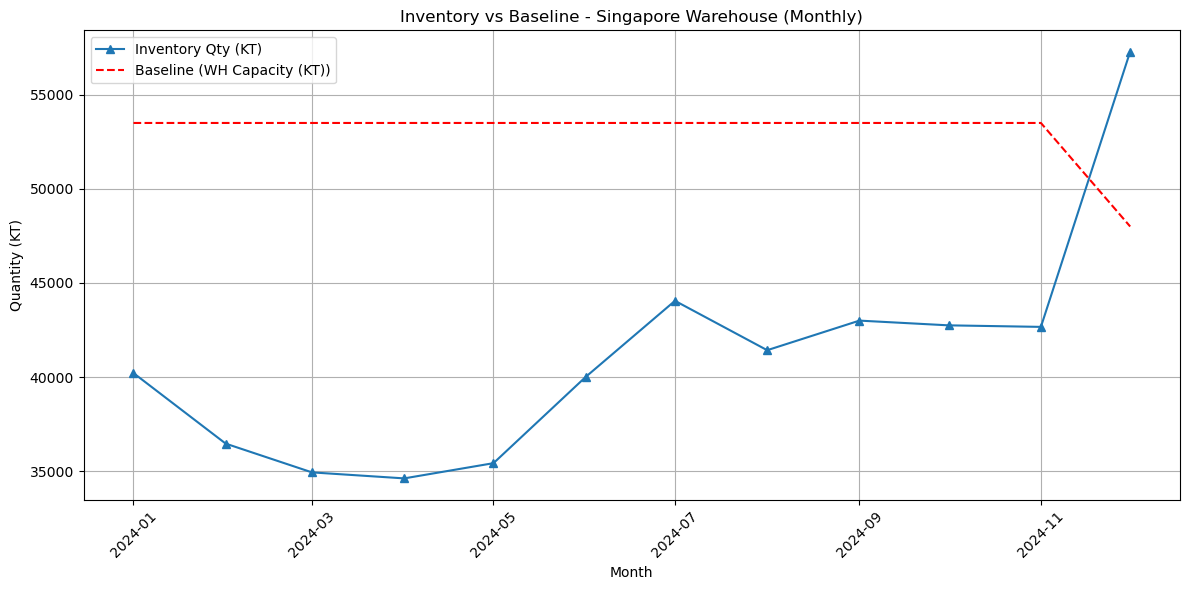

In [861]:
plt.figure(figsize=(12, 6))
plt.plot(df['month'], df['Quantity_MT_Inventory'], marker='^', label='Inventory Qty (KT)')
plt.plot(df['month'], y, color='r', linestyle='--', label='Baseline (WH Capacity (KT))')
plt.title('Inventory vs Baseline - Singapore Warehouse (Monthly)')
plt.xlabel('Month')
plt.ylabel('Quantity (KT)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

# **Forecasting**

In [862]:
singapore_data = {
    'Month': ['Jan-24', 'Feb-24', 'Mar-24', 'Apr-24', 'May-24', 'Jun-24', 'Jul-24', 'Aug-24', 'Sep-24', 'Oct-24', 'Nov-24', 'Dec-24'],
    'Total Cap (KT)': [53500, 53500, 53500, 53500, 53500, 53500, 53500, 53500, 53500, 53500, 53500, 48000],
    'Predicted Outbound (KT)': [8710, 10950, 9360, 7520, 10740, 9440, 11380, 11330, 16700, 20980, 16470, 13970],
    'Predicted Inventory (KT)': [39581, 36763, 35049, 35663, 36374, 40500, 44288, 41769, 41735, 41849, 40327, 15375.05]
}

singapore_predicted = pd.DataFrame(singapore_data)
singapore_predicted['Month'] = pd.to_datetime(singapore_predicted['Month'], format='%b-%y').dt.to_period('M')

In [863]:
singapore_predicted

,Month,Total Cap (KT),Predicted Outbound (KT),Predicted Inventory (KT)
0,2024-01,53500,8710,39581.00
1,2024-02,53500,10950,36763.00
2,2024-03,53500,9360,35049.00
3,2024-04,53500,7520,35663.00
4,2024-05,53500,10740,36374.00
5,2024-06,53500,9440,40500.00
6,2024-07,53500,11380,44288.00
7,2024-08,53500,11330,41769.00
8,2024-09,53500,16700,41735.00
9,2024-10,53500,20980,41849.00


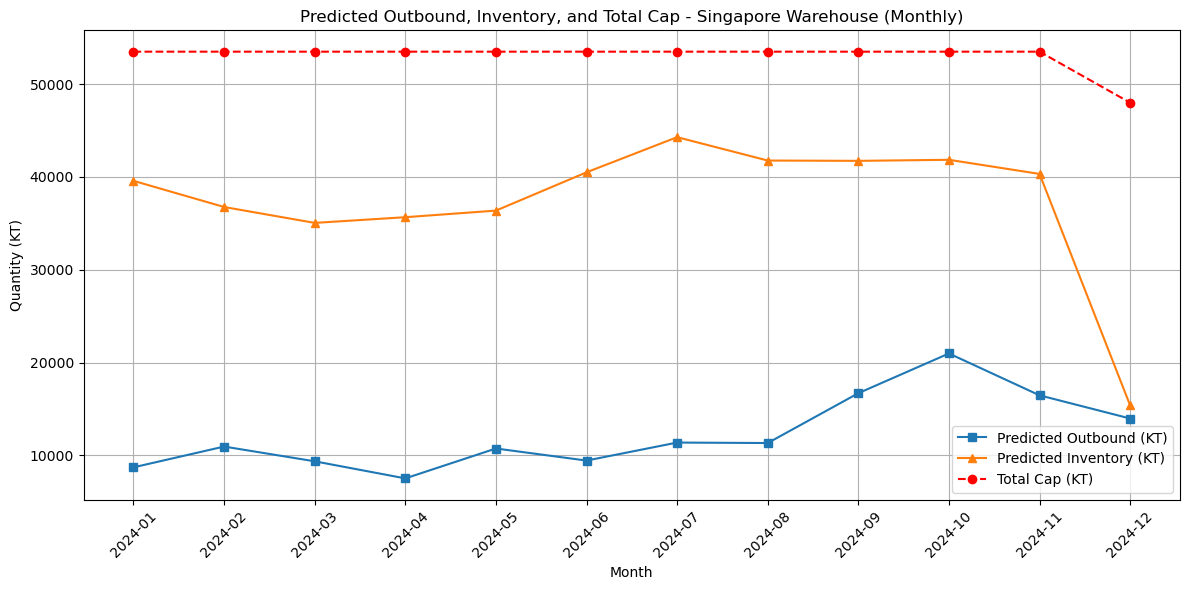

In [864]:
plt.figure(figsize=(12, 6))

plt.plot(singapore_predicted['Month'].astype(str), singapore_predicted['Predicted Outbound (KT)'], marker='s', label='Predicted Outbound (KT)')
plt.plot(singapore_predicted['Month'].astype(str), singapore_predicted['Predicted Inventory (KT)'], marker='^', label='Predicted Inventory (KT)')
plt.plot(singapore_predicted['Month'].astype(str), singapore_predicted['Total Cap (KT)'], marker='o', linestyle='--', color='red', label='Total Cap (KT)')

plt.title('Predicted Outbound, Inventory, and Total Cap - Singapore Warehouse (Monthly)')
plt.xlabel('Month')
plt.ylabel('Quantity (KT)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Inventory Pred vs Actual**

In [865]:
comparison = df[['month', 'Quantity_MT_Inventory']].copy()
comparison['Predicted_Inventory'] = comparison['month'].apply(
    lambda m: singapore_predicted.loc[singapore_predicted['Month'].dt.to_timestamp() == m, 'Predicted Inventory (KT)'].values[0]
    if not singapore_predicted.loc[singapore_predicted['Month'].dt.to_timestamp() == m].empty else None
)
comparison['Deviation'] = comparison['Quantity_MT_Inventory'] - comparison['Predicted_Inventory']

print("Actual vs Predicted Inventory (Singapore Warehouse):")
comparison

Actual vs Predicted Inventory (Singapore Warehouse):


,month,Quantity_MT_Inventory,Predicted_Inventory,Deviation
0,2024-01-01,40213.850,39581.00,632.850
1,2024-02-01,36465.800,36763.00,-297.200
2,2024-03-01,34938.300,35049.00,-110.700
3,2024-04-01,34619.875,35663.00,-1043.125
4,2024-05-01,35428.425,36374.00,-945.575
5,2024-06-01,40010.550,40500.00,-489.450
6,2024-07-01,44052.125,44288.00,-235.875
7,2024-08-01,41428.880,41769.00,-340.120
8,2024-09-01,43000.974,41735.00,1265.974
9,2024-10-01,42749.300,41849.00,900.300


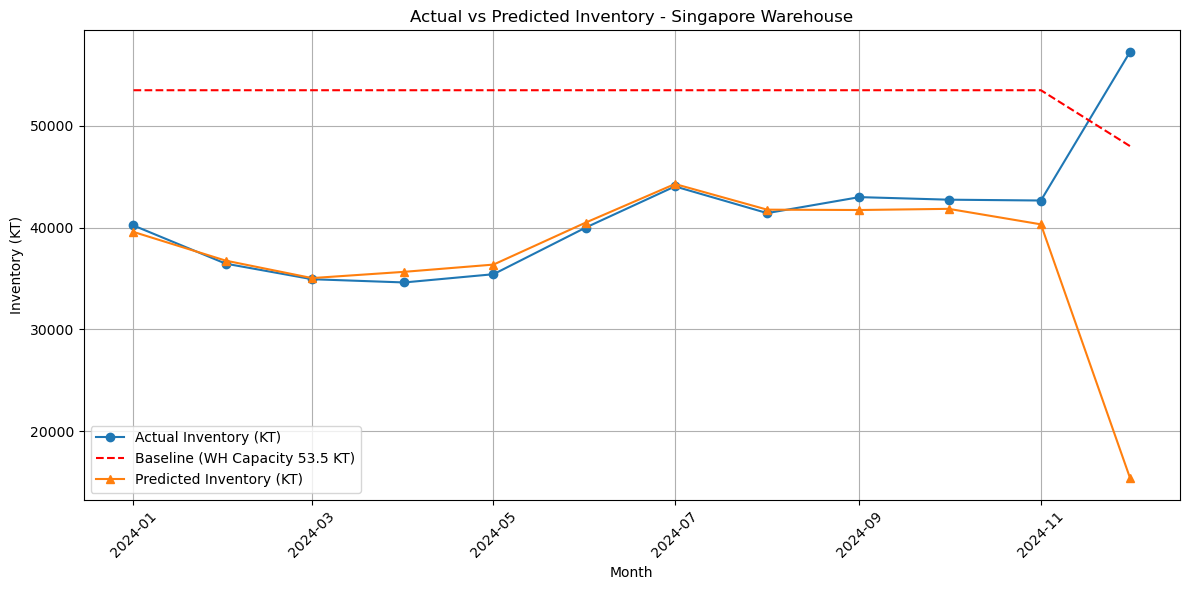

In [866]:
plt.figure(figsize=(12, 6))
plt.plot(df['month'], df['Quantity_MT_Inventory'], marker='o', label='Actual Inventory (KT)')
plt.plot(df['month'], y, color='r', linestyle='--', label='Baseline (WH Capacity 53.5 KT)')
plt.plot(singapore_predicted['Month'].dt.to_timestamp(), singapore_predicted['Predicted Inventory (KT)'], marker='^', label='Predicted Inventory (KT)')
plt.title('Actual vs Predicted Inventory - Singapore Warehouse')
plt.xlabel('Month')
plt.ylabel('Inventory (KT)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## **Adjust Inventory Predicted**

In [867]:
comparison_valid = comparison.dropna(subset=['Predicted_Inventory','Quantity_MT_Inventory'])

X = comparison_valid[['Predicted_Inventory']]
y = comparison_valid['Quantity_MT_Inventory']

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

cut_off_date = pd.to_datetime('2024-09-30')

train_mask = comparison_valid['month'] <= cut_off_date
test_mask = comparison_valid['month'] > cut_off_date

X_train = X_scaled[train_mask]
X_test = X_scaled[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

xgb = xgb.XGBRegressor(
    n_estimators=150,
    learning_rate=0.02,   
    max_depth=3,           
    subsample=0.8,          
    colsample_bytree=0.8,   
    reg_alpha=0.5,          
    reg_lambda=1.0,           
    random_state=42
)

xgb.fit(X_train, y_train)

y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

print(f"[Train] MAE: {mean_absolute_error(y_train, y_train_pred):.2f} | RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.2f}")
print(f"[Test ] MAE: {mean_absolute_error(y_test, y_test_pred):.2f} | RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f}")

[Train] MAE: 525.55 | RMSE: 651.77
[Test ] MAE: 8506.06 | RMSE: 12700.60


In [868]:
X_all = scaler.transform(comparison[['Predicted_Inventory']].fillna(0))
comparison['Predicted_Adjusted'] = xgb.predict(X_all)
comparison['Deviation_Adjusted'] = comparison['Quantity_MT_Inventory'] - comparison['Predicted_Adjusted']

fig = px.line(comparison, x='month', y=['Quantity_MT_Inventory', 'Predicted_Inventory', 'Predicted_Adjusted'],
              title='Actual vs Predicted Inventory', markers=True)
fig.update_layout(yaxis_title='Inventory (KT)', xaxis_title='Month')
fig.show()

# **Outbound Pred vs Actual**

In [869]:
outbound_comparison = df[['month', 'Quantity_KT_Out']].copy()
outbound_comparison['Predicted_Outbound'] = outbound_comparison['month'].apply(
    lambda m: singapore_predicted.loc[singapore_predicted['Month'].dt.to_timestamp() == m, 'Predicted Outbound (KT)'].values[0]
    if not singapore_predicted.loc[singapore_predicted['Month'].dt.to_timestamp() == m].empty else None
)
outbound_comparison['Deviation'] = outbound_comparison['Quantity_KT_Out'] - outbound_comparison['Predicted_Outbound']

print("Actual vs Predicted Outbound (Singapore Warehouse):")
outbound_comparison

Actual vs Predicted Outbound (Singapore Warehouse):


,month,Quantity_KT_Out,Predicted_Outbound,Deviation
0,2024-01-01,8030.355,8710,-679.645
1,2024-02-01,10046.795,10950,-903.205
2,2024-03-01,11107.855,9360,1747.855
3,2024-04-01,8797.185,7520,1277.185
4,2024-05-01,10501.950,10740,-238.050
5,2024-06-01,12455.665,9440,3015.665
6,2024-07-01,12305.930,11380,925.930
7,2024-08-01,13300.645,11330,1970.645
8,2024-09-01,12277.775,16700,-4422.225
9,2024-10-01,15154.065,20980,-5825.935


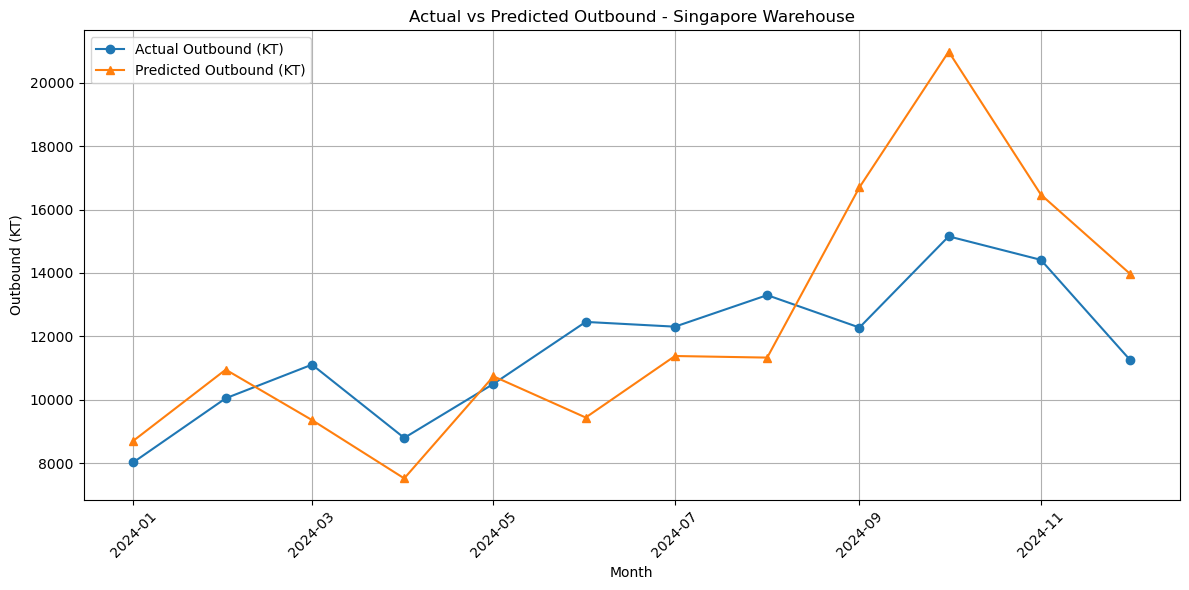

In [870]:
plt.figure(figsize=(12, 6))
plt.plot(df['month'], df['Quantity_KT_Out'], marker='o', label='Actual Outbound (KT)')
plt.plot(singapore_predicted['Month'].dt.to_timestamp(), singapore_predicted['Predicted Outbound (KT)'], marker='^', label='Predicted Outbound (KT)')
plt.title('Actual vs Predicted Outbound - Singapore Warehouse')
plt.xlabel('Month')
plt.ylabel('Outbound (KT)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Adjust Outbound Predicted**

In [871]:
outbound_valid = outbound_comparison.dropna(subset=['Predicted_Outbound', 'Quantity_KT_Out'])

X_out = outbound_valid[['Predicted_Outbound']]
y_out = outbound_valid['Quantity_KT_Out']

scaler_out = RobustScaler()
X_out_scaled = scaler_out.fit_transform(X_out)

train_mask = outbound_valid['month'] <= cut_off_date
test_mask = outbound_valid['month'] > cut_off_date

X_out_train = X_out_scaled[train_mask]  
X_out_test = X_out_scaled[test_mask]   
y_out_train = y_out[train_mask]       
y_out_test = y_out[test_mask]        

model = Ridge(alpha=0.45)  
model.fit(X_out_train, y_out_train)

y_out_train_pred = model.predict(X_out_train)
y_out_test_pred = model.predict(X_out_test)

print(f"[Train] MAE: {mean_absolute_error(y_out_train, y_out_train_pred):.2f} | RMSE: {np.sqrt(mean_squared_error(y_out_train, y_out_train_pred)):.2f}")
print(f"[Test ] MAE: {mean_absolute_error(y_out_test, y_out_test_pred):.2f} | RMSE: {np.sqrt(mean_squared_error(y_out_test, y_out_test_pred)):.2f}")

[Train] MAE: 1250.29 | RMSE: 1413.48
[Test ] MAE: 1116.69 | RMSE: 1177.54


In [872]:
X_out_all = scaler_out.transform(outbound_comparison[['Predicted_Outbound']].fillna(0))
outbound_comparison['Predicted_Outbound_Adjusted'] = model.predict(X_out_all)
outbound_comparison['Deviation_Adjusted'] = outbound_comparison['Quantity_KT_Out'] - outbound_comparison['Predicted_Outbound_Adjusted']

fig = px.line(
    outbound_comparison,
    x='month',
    y=['Quantity_KT_Out', 'Predicted_Outbound', 'Predicted_Outbound_Adjusted'],
    title='Actual vs Predicted Outbound',
    markers=True
)

fig.update_layout(yaxis_title='Outbound (KT)', xaxis_title='Month')
fig.show()

---

# **Optimization**

### **Create Dataframe For Optimization Model**

In [873]:
optimize = pd.DataFrame({
    'Actual Inbound': Inbound_monthly_singapore['Quantity_KT_In'],
    'Actual Outbound': Outbound_monthly_singapore['Quantity_KT_Out'],
    'Actual Inventory': Inventory_monthly_singapore['Quantity_MT_Inventory'],
    'Adjusted Inventory': comparison['Predicted_Adjusted'],
    'Adjusted Outbound': outbound_comparison['Predicted_Outbound_Adjusted'],
    'Capacity' : singapore_predicted['Total Cap (KT)'].values
})
optimize['Overflow'] = optimize['Adjusted Inventory'] > optimize['Capacity']

In [874]:
optimize

,Actual Inbound,Actual Outbound,Actual Inventory,Adjusted Inventory,Adjusted Outbound,Capacity,Overflow
0,6867.000,8030.355,40213.850,40000.843750,10366.865236,53500,False
1,7128.995,10046.795,36465.800,36653.246094,11064.165351,53500,False
2,15858.001,11107.855,34938.300,35476.148438,10569.206787,53500,False
3,14027.350,8797.185,34619.875,35476.148438,9996.424549,53500,False
4,12248.625,10501.950,35428.425,35701.753906,10998.793465,53500,False
5,6233.500,12455.665,40010.550,40208.191406,10594.110363,53500,False
6,8659.000,12305.930,44052.125,42692.984375,11198.022070,53500,False
7,15971.750,13300.645,41428.880,41709.121094,11182.457335,53500,False
8,10510.625,12277.775,43000.974,42175.953125,12854.109844,53500,False
9,9600.750,15154.065,42749.300,41709.121094,14186.451137,53500,False


In [875]:
new_records = [
    [15000.0, 14500.0, 52000.0, 40000.0, 13000.0, 53500.0, False],
    [24000.0, 15000.0, 60000.0, 58000.0, 15500.0, 53500.0, False],
    [40000.0, 14000.0, 80000.0, 36000.0, 13500.0, 52000.0, False]
]

columns = ['Actual Inbound', 'Actual Outbound', 'Actual Inventory',
           'Adjusted Inventory', 'Adjusted Outbound', 'Capacity', 'Overflow']

new_df = pd.DataFrame(new_records, columns=columns)
optimize = pd.concat([optimize, new_df], ignore_index=True)

# ดูผลลัพธ์ล่าสุด
optimize.tail(5)




,Actual Inbound,Actual Outbound,Actual Inventory,Adjusted Inventory,Adjusted Outbound,Capacity,Overflow
10,4344.75,14412.775,42667.825,40000.843750,12782.512065,53500.0,False
11,540.00,11252.095,57287.175,35476.148438,12004.275329,48000.0,False
12,15000.00,14500.000,52000.000,40000.000000,13000.000000,53500.0,False
13,24000.00,15000.000,60000.000,58000.000000,15500.000000,53500.0,False
14,40000.00,14000.000,80000.000,36000.000000,13500.000000,52000.0,False


### ---**You Can Append New Records to the `optimize` DataFrame**---

## **Optimization Model Function: Backtesting on Historical Data**

- **Define a Function that applies the optimization logic using historical data to verify model correctness, behavior, and feasibility before applying to future scenarios.**

In [ ]:
def run_optimization(optimize):
    model = LpProblem("Inventory_Optimization", LpMinimize)
    n = len(optimize)

    inbound_vars = [LpVariable(f"Inbound_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    outbound_vars = [LpVariable(f"Outbound_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    inventory_vars = [LpVariable(f"Inventory_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    overflow_vars = [LpVariable(f"Overflow_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    understock_vars = [LpVariable(f"Understock_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]

    capacity = optimize['Capacity'].values
    adjusted_outbound = optimize['Actual Outbound'].values
    cap_70 = 0.7 * capacity
    cap_80 = 0.8 * capacity

    # Objective: penalize overflow and understock, reward outbound
    model += (
        lpSum(overflow_vars) * 1 +
        lpSum(understock_vars) * 1 -
        lpSum(outbound_vars)
    )

    for i in range(n):
        if i == 0:
            model += inventory_vars[i] == optimize['Actual Inventory'].iloc[0] + inbound_vars[i] - outbound_vars[i]
        else:
            model += inventory_vars[i] == inventory_vars[i - 1] + inbound_vars[i] - outbound_vars[i]

        model += outbound_vars[i] <= adjusted_outbound[i]
        model += inbound_vars[i] >= 5  # MOQ

        # Tight overflow/understock constraints
        model += overflow_vars[i] >= inventory_vars[i] - cap_80[i]
        model += understock_vars[i] >= cap_70[i] - inventory_vars[i]
        model += overflow_vars[i] >= 0
        model += understock_vars[i] >= 0

    model.solve()

    optimize['Optimized Inbound'] = [inbound_vars[i].varValue for i in range(n)]
    optimize['Optimized Outbound'] = [outbound_vars[i].varValue for i in range(n)]
    optimize['Optimized Inventory'] = [inventory_vars[i].varValue for i in range(n)]
    optimize['Overflow'] = [overflow_vars[i].varValue for i in range(n)]
    optimize['Understock'] = [understock_vars[i].varValue for i in range(n)]
    optimize['Cap_70'] = cap_70
    optimize['Cap_80'] = cap_80

    return optimize


In [877]:
opt_head_9 = optimize.head(9).copy()

In [878]:
opt_head_9 = run_optimization(opt_head_9)
opt_head_9['Cap_70'] = opt_head_9['Capacity'] * 0.70
opt_head_9['Cap_80'] = opt_head_9['Capacity'] * 0.80

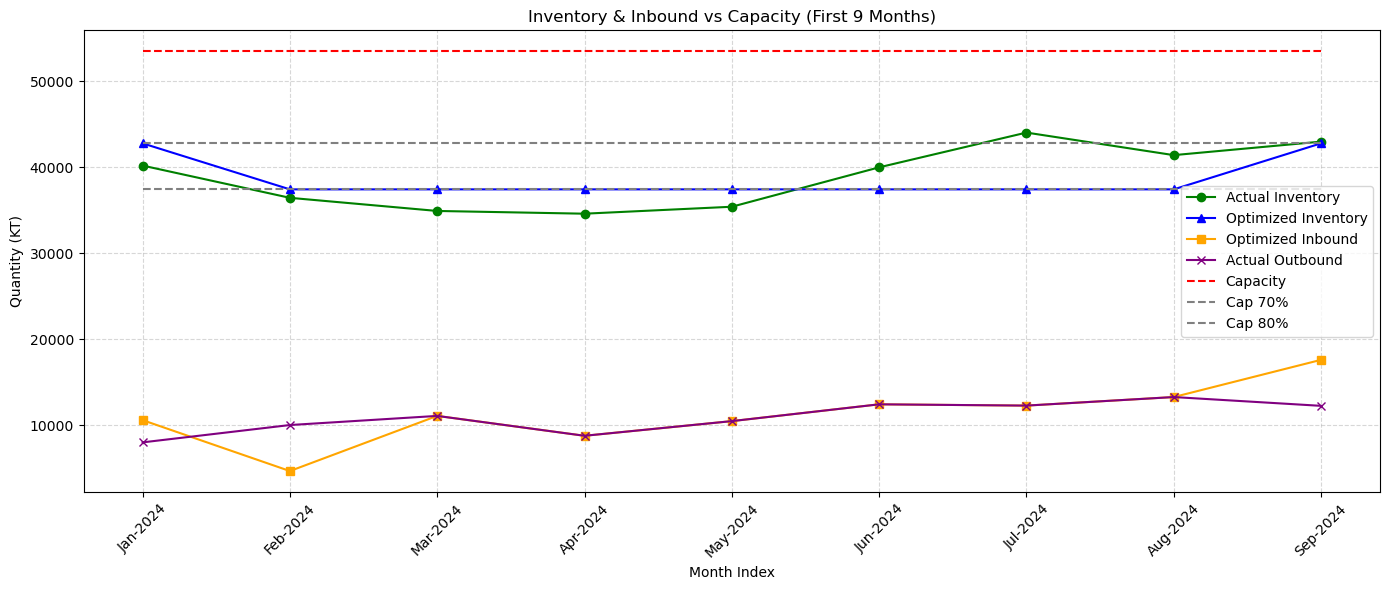

In [896]:
opt_head_9 = opt_head_9.sort_index()
x1 = opt_head_9.index
month_labels = df.loc[x1, 'month'].dt.strftime('%b-%Y').values
plt.figure(figsize=(14,6))

plt.plot(x1, opt_head_9['Actual Inventory'], label='Actual Inventory', color='green', marker='o')
plt.plot(x1, opt_head_9['Optimized Inventory'], label='Optimized Inventory', color='blue', marker='^')
plt.plot(x1, opt_head_9['Optimized Inbound'], label='Optimized Inbound', color='orange', marker='s')
plt.plot(x1, opt_head_9['Actual Outbound'], label='Actual Outbound', color='purple', marker='x' )
plt.plot(x1, opt_head_9['Capacity'], label='Capacity', color='red', linestyle='--')
plt.plot(x1, opt_head_9['Cap_70'], label='Cap 70%', color='gray', linestyle='--')
plt.plot(x1, opt_head_9['Cap_80'], label='Cap 80%', color='gray', linestyle='--')

plt.title('Inventory & Inbound vs Capacity (First 9 Months)')
plt.xlabel('Month Index')
plt.ylabel('Quantity (KT)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(x1, month_labels, rotation=45)
plt.tight_layout()
plt.show()

---

## **Build a New Optimization Function for `pred_data`**

- **Construct a new optimization function that applies the same logic as the previous model, adapted to handle `pred_data` (forecasted or incoming new data).**

In [ ]:
def run_forecast_optimization(df_forecast, last_inventory, fixed_inbound_dict=None):
    n = len(df_forecast)

    model = LpProblem("Inventory_Optimization", LpMinimize)

    # Variables
    inbound_vars = [LpVariable(f"Inbound_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    outbound_vars = [LpVariable(f"Outbound_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    inventory_vars = [LpVariable(f"Inventory_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    overflow_vars = [LpVariable(f"Overflow_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    understock_vars = [LpVariable(f"Understock_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]

    # Parameters
    adjusted_outbound = df_forecast['Adjusted Outbound'].values
    capacity = df_forecast['Capacity'].values

    cap_80 = 0.8 * capacity
    cap_70 = 0.7 * capacity

    # Inventory balance constraint
    for i in range(n):
        if i == 0:
            model += inventory_vars[i] == last_inventory + inbound_vars[i] - outbound_vars[i]
        else:
            model += inventory_vars[i] == inventory_vars[i-1] + inbound_vars[i] - outbound_vars[i]

    # Fix inbound where known (if fixed_inbound_dict is provided)
    if fixed_inbound_dict:
        for relative_idx, value in fixed_inbound_dict.items():
            if 0 <= relative_idx < n:
                model += inbound_vars[relative_idx] == value

    # Outbound constraints
    for i in range(n):
        model += outbound_vars[i] <= adjusted_outbound[i]
        model += inbound_vars[i] >= 0  # Min inbound

    # Overflow & understock constraints
    for i in range(n):
        model += overflow_vars[i] >= inventory_vars[i] - cap_80[i]
        model += overflow_vars[i] >= 0
        model += understock_vars[i] >= cap_70[i] - inventory_vars[i]
        model += understock_vars[i] >= 0

    # Objective
    model += -lpSum(outbound_vars) + lpSum(overflow_vars) * 1.5 + lpSum(understock_vars) * 0.5

    model.solve()

    # Results
    df_result = df_forecast.copy()
    df_result['Optimized Inbound'] = [v.value() for v in inbound_vars]
    df_result['Optimized Outbound'] = [v.value() for v in outbound_vars]
    df_result['Optimized Inventory'] = [v.value() for v in inventory_vars]
    df_result['Overflow'] = [v.value() for v in overflow_vars]
    df_result['Understock'] = [v.value() for v in understock_vars]
    df_result['Cap_70'] = cap_70
    df_result['Cap_80'] = cap_80

    return df_result

In [881]:
optimize.index = optimize.index + 1
optimize

,Actual Inbound,Actual Outbound,Actual Inventory,Adjusted Inventory,Adjusted Outbound,Capacity,Overflow
1,6867.000,8030.355,40213.850,40000.843750,10366.865236,53500.0,False
2,7128.995,10046.795,36465.800,36653.246094,11064.165351,53500.0,False
3,15858.001,11107.855,34938.300,35476.148438,10569.206787,53500.0,False
4,14027.350,8797.185,34619.875,35476.148438,9996.424549,53500.0,False
5,12248.625,10501.950,35428.425,35701.753906,10998.793465,53500.0,False
6,6233.500,12455.665,40010.550,40208.191406,10594.110363,53500.0,False
7,8659.000,12305.930,44052.125,42692.984375,11198.022070,53500.0,False
8,15971.750,13300.645,41428.880,41709.121094,11182.457335,53500.0,False
9,10510.625,12277.775,43000.974,42175.953125,12854.109844,53500.0,False
10,9600.750,15154.065,42749.300,41709.121094,14186.451137,53500.0,False


### **Initial Target for the New Optimization Model: `optimize.iloc[-3:]` (Last 3 Records)**

In [882]:
# optimizefornew = optimize[['Adjusted Outbound', 'Capacity', 'Actual Inventory']]

In [883]:
# opt_last3 = optimizefornew.iloc[-3:].copy()
# opt_last3 = optimize.iloc[-3:].copy()
opt_last3 = optimize.iloc[-3:].copy()

In [884]:
opt_last3

,Actual Inbound,Actual Outbound,Actual Inventory,Adjusted Inventory,Adjusted Outbound,Capacity,Overflow
13,15000.0,14500.0,52000.0,40000.0,13000.0,53500.0,False
14,24000.0,15000.0,60000.0,58000.0,15500.0,53500.0,False
15,40000.0,14000.0,80000.0,36000.0,13500.0,52000.0,False


- **The latest inventory value is a key input to the optimization model, as all calculations are anchored from this current stock level.**

In [885]:
opt_start_idx = opt_last3.index[0] 
last_inventory = optimize.loc[opt_start_idx - 1, 'Actual Inventory']
last_inventory

57287.175

In [886]:
# opt_last3 = opt_last3.iloc[2:]

In [887]:
fixed_inbound_dict = {
    0: optimize.loc[opt_start_idx, 'Actual Inbound'],       # เดือน 10
    1: optimize.loc[opt_start_idx + 1, 'Actual Inbound'],   # เดือน 11
}

🔁 การทำให้ rolling ใช้ได้เสมอ:
ทุกเดือนคุณจะ:

fix inbound ที่รู้แน่แล้ว (lead time ผ่านไปแล้ว)

คำนวณ inventory ล่าสุด

optimize เฉพาะเดือนที่ยังไม่ถูกสั่ง inbound

In [888]:
opt_last3 = run_forecast_optimization(opt_last3, last_inventory, fixed_inbound_dict=fixed_inbound_dict)
opt_last3 = opt_last3.sort_index()

In [889]:
opt_last3

,Actual Inbound,Actual Outbound,Actual Inventory,Adjusted Inventory,Adjusted Outbound,Capacity,Overflow,Optimized Inbound,Optimized Outbound,Optimized Inventory,Understock,Cap_70,Cap_80
13,15000.0,14500.0,52000.0,40000.0,13000.0,53500.0,16487.175,15000.0,13000.0,59287.175,0.0,37450.0,42800.0
14,24000.0,15000.0,60000.0,58000.0,15500.0,53500.0,24987.175,24000.0,15500.0,67787.175,0.0,37450.0,42800.0
15,40000.0,14000.0,80000.0,36000.0,13500.0,52000.0,12692.175,5.0,13500.0,54292.175,0.0,36400.0,41600.0


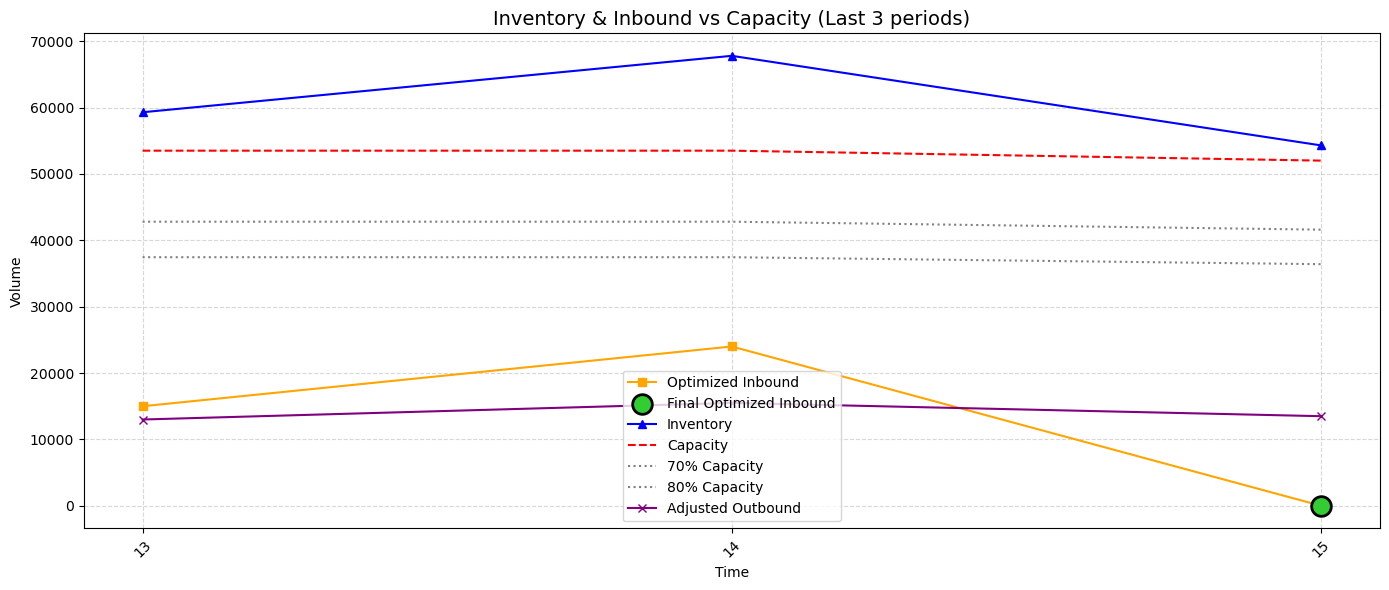

In [890]:
x = opt_last3.index
y_inbound = opt_last3['Optimized Inbound']

plt.figure(figsize=(14,6))

# เส้นหลัก Optimized Inbound
plt.plot(x, y_inbound, label='Optimized Inbound', color='orange', marker='s')

# จุดสุดท้าย (เด่นๆ)
last_x = x[-1]
last_y = y_inbound.iloc[-1]

plt.scatter(
    last_x, last_y,
    color='limegreen',       # สีเขียวเด่น
    s=200,                   # ขนาดใหญ่
    edgecolors='black',      # ขอบดำ
    linewidths=2,
    zorder=10,               # ให้อยู่บนสุด
    label='Final Optimized Inbound'
)

# เพิ่ม Annotation
# plt.annotate(
#     f'Final: {last_y:.0f}',
#     xy=(last_x, last_y),
#     xytext=(last_x, last_y + 60),  # ปรับระยะห่างข้อความ
#     fontsize=11,
#     color='green',
#     weight='bold',
#     arrowprops=dict(
#         facecolor='limegreen',
#         edgecolor='black',
#         arrowstyle='->',
#         lw=2
#     )
# )

# เส้นอื่น ๆ
plt.plot(x, opt_last3['Optimized Inventory'], label='Inventory', color='blue', marker='^')
plt.plot(x, opt_last3['Capacity'], label='Capacity', color='red', linestyle='--')
plt.plot(x, opt_last3['Cap_70'], label='70% Capacity', color='gray', linestyle=':')
plt.plot(x, opt_last3['Cap_80'], label='80% Capacity', color='gray', linestyle=':')
plt.plot(x, opt_last3['Adjusted Outbound'], label='Adjusted Outbound', color='purple', marker='x')
# plt.plot(x, opt_last3['Optimized Outbound'], label='Optimized Outbound', color='brown', marker='D')

# รูปแบบกราฟ
plt.title('Inventory & Inbound vs Capacity (Last 3 periods)', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(x, x, rotation=45)
plt.tight_layout()
plt.show()


In [891]:
combined_df = pd.concat([opt_head_9, opt_last3], ignore_index=True)

In [892]:
# combined_df.to_csv('optim_singapore.csv', index=False, encoding='utf-8-sig')

In [893]:
combined_df

,Actual Inbound,Actual Outbound,Actual Inventory,Adjusted Inventory,Adjusted Outbound,Capacity,Overflow,Optimized Inbound,Optimized Outbound,Optimized Inventory,Understock,Cap_70,Cap_80
0,6867.000,8030.355,40213.850,40000.843750,10366.865236,53500.0,0.000,10616.505,8030.355,42800.000,0.0,37450.0,42800.0
1,7128.995,10046.795,36465.800,36653.246094,11064.165351,53500.0,0.000,4696.795,10046.795,37450.000,0.0,37450.0,42800.0
2,15858.001,11107.855,34938.300,35476.148438,10569.206787,53500.0,0.000,11107.855,11107.855,37450.000,0.0,37450.0,42800.0
3,14027.350,8797.185,34619.875,35476.148438,9996.424549,53500.0,0.000,8797.185,8797.185,37450.000,0.0,37450.0,42800.0
4,12248.625,10501.950,35428.425,35701.753906,10998.793465,53500.0,0.000,10501.950,10501.950,37450.000,0.0,37450.0,42800.0
5,6233.500,12455.665,40010.550,40208.191406,10594.110363,53500.0,0.000,12455.665,12455.665,37450.000,0.0,37450.0,42800.0
6,8659.000,12305.930,44052.125,42692.984375,11198.022070,53500.0,0.000,12305.930,12305.930,37450.000,0.0,37450.0,42800.0
7,15971.750,13300.645,41428.880,41709.121094,11182.457335,53500.0,0.000,13300.645,13300.645,37450.000,0.0,37450.0,42800.0
8,10510.625,12277.775,43000.974,42175.953125,12854.109844,53500.0,0.000,17627.775,12277.775,42800.000,0.0,37450.0,42800.0
9,15000.000,14500.000,52000.000,40000.000000,13000.000000,53500.0,16487.175,15000.000,13000.000,59287.175,0.0,37450.0,42800.0


---

# **Try build Optim 3 months after optim. mod from PT**

---

**End of Notebook – Thank you**